In [181]:
import pandas as pd
import os
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, BDeuScore, PC, MmhcEstimator
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator

### Load data

In [141]:
data_dir = '../data'
data_file = 'cmc.data'

data_path = os.path.join(data_dir, data_file)

In [142]:
data = pd.read_csv(data_path, header=None)

# setting column names
data.columns = [
    'wife_age', 'wife_edu', 'husband_edu', 'n_children', 'wife_religion', 
    'wife_working', 'husband_occup', 'sol_index', 'media_exposure', 
    'class'
]
X = data[['wife_age', 'wife_edu', 'husband_edu', 'n_children', 'wife_religion', 
          'wife_working', 'husband_occup', 'sol_index', 'media_exposure']]

### Helpers 

In [143]:
def plot_network(bn):
    plt.figure(figsize=(14, 8))
    pos=graphviz_layout(bn, prog='dot')
    nx.draw(
        bn,
        pos=pos,
        with_labels=True,
        node_color='white',
        edgecolors='black',
        node_size=8000,
        arrowsize=20,
    )
    plt.show()

### Discretization

In [144]:
def discritize(attribute,
               X,
               n_bins):
    kbins = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    values = X[attribute].to_numpy()
    values = values.reshape((len(values),1))
    X[attribute+"_discrete"] = kbins.fit_transform(values)
    return X

In [145]:
X = discritize('wife_age',X,10)

In [146]:
X

,wife_age,wife_edu,husband_edu,n_children,wife_religion,wife_working,husband_occup,sol_index,media_exposure,wife_age_discrete
0,24,2,3,3,1,1,2,3,0,2.0
1,45,1,3,10,1,1,3,4,0,8.0
2,43,2,3,7,1,1,3,4,0,8.0
3,42,3,2,9,1,1,3,3,0,7.0
4,36,3,3,8,1,1,3,2,0,6.0
...,...,...,...,...,...,...,...,...,...,...
1468,33,4,4,2,1,0,2,4,0,5.0
1469,33,4,4,3,1,1,1,4,0,5.0
1470,39,3,3,8,1,0,1,4,0,6.0
1471,33,3,3,4,1,0,2,2,0,5.0


In [147]:
X = X[['wife_age_discrete', 'wife_edu', 'husband_edu', 'n_children', 'wife_religion', 
          'wife_working', 'husband_occup', 'sol_index', 'media_exposure']]

### Bayesian Network - structures exploration

#### Tabu Search (score-based)

Performs local hill climb search to estimates the DAG structure that has optimal score, according to the scoring method supplied. Starts at model start_dag and proceeds by step-by-step network modifications until a local maximum is reached. Only estimates network structure, no parametrization.

**BIC score** 

The BIC/MDL score ("Bayesian Information Criterion", also "Minimal Descriptive Length") is a
log-likelihood score with an additional penalty for network complexity, to avoid overfitting.

  0%|                                                                           | 5/1000000 [00:01<58:03:23,  4.78it/s]


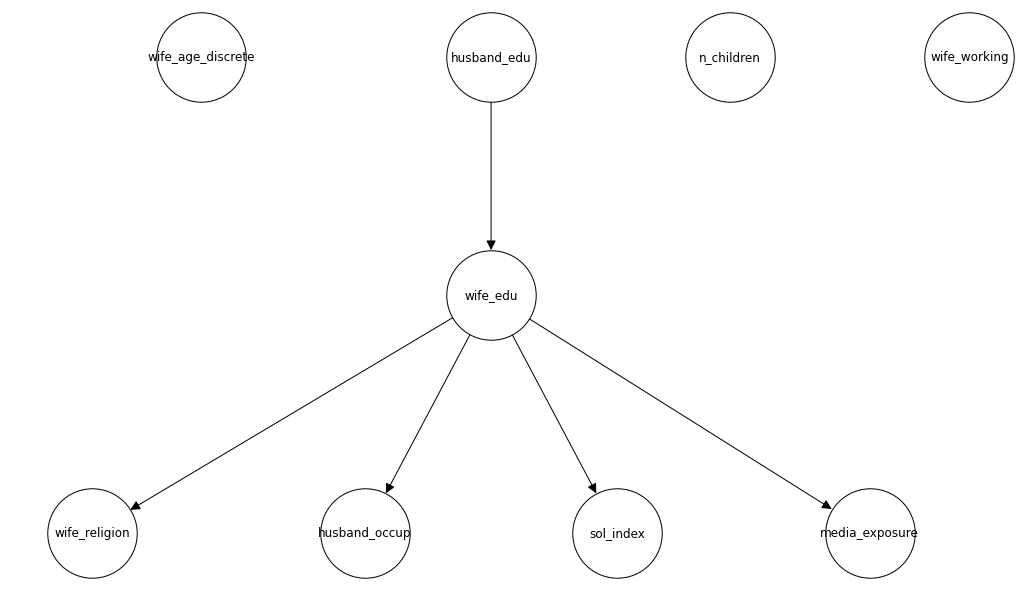

In [148]:
est = HillClimbSearch(X)
best_model = est.estimate(scoring_method=BicScore(X))
plot_network(best_model)

**K2 score**

The K2 score is the result of setting all Dirichlet hyperparameters/pseudo_counts to 1.

  0%|                                                                          | 11/1000000 [00:01<38:32:05,  7.21it/s]


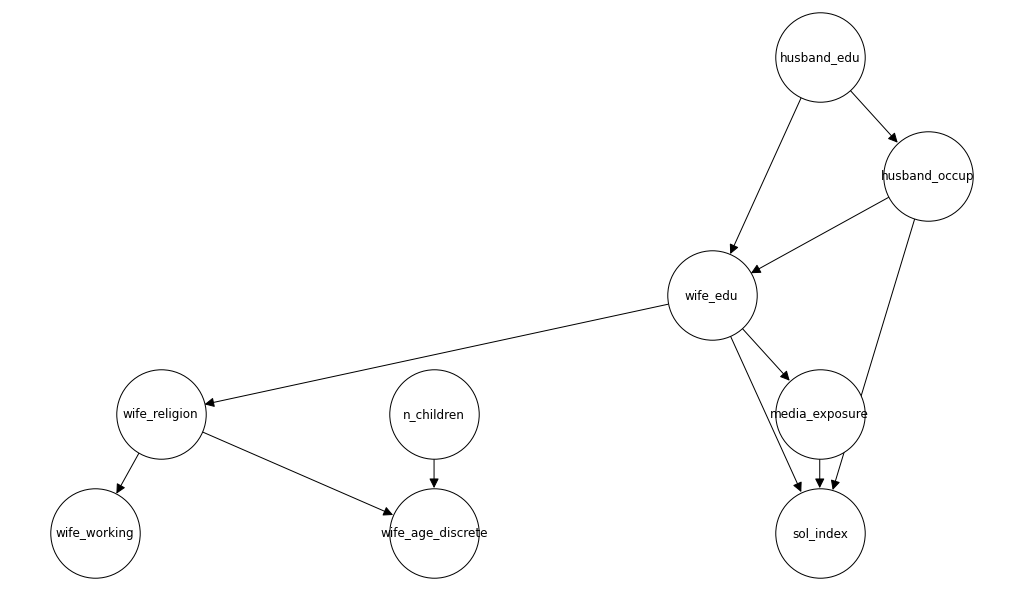

In [149]:
est = HillClimbSearch(X)
best_model = est.estimate(scoring_method=K2Score(X))
plot_network(best_model)

**BDeu score**

The BDeu score is the result of setting all Dirichlet hyperparameters/pseudo_counts to
`equivalent_sample_size/variable_cardinality`.

  0%|                                                                           | 9/1000000 [00:01<37:59:37,  7.31it/s]


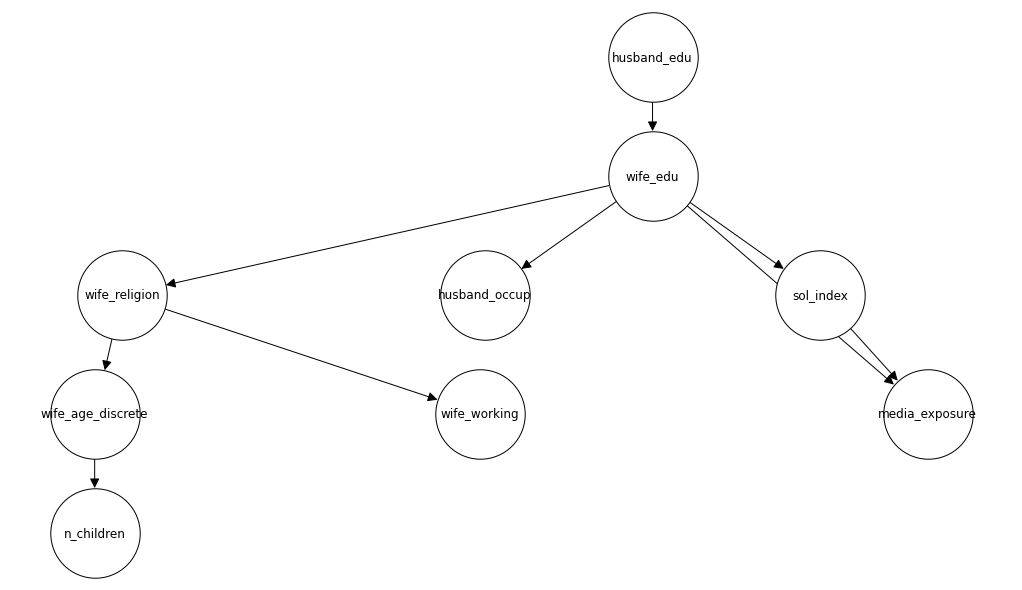

In [150]:
est = HillClimbSearch(X)
best_model = est.estimate(scoring_method=BDeuScore(X))
plot_network(best_model)

#### PC (constraint-based)

Estimates a DAG/PDAG from the given dataset using the PC algorithm which is a constraint-based structure learning algorithm. The independencies in the dataset are identified by doing statistical independece test. This method returns a DAG/PDAG structure which is faithful to the independencies implied by the dataset

Working for n conditional variables: 5: 100%|████████████████████████████████████████████| 5/5 [00:24<00:00,  4.49s/it]C:\Users\User\Anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 5: 100%|████████████████████████████████████████████| 5/5 [00:24<00:00,  4.92s/it]


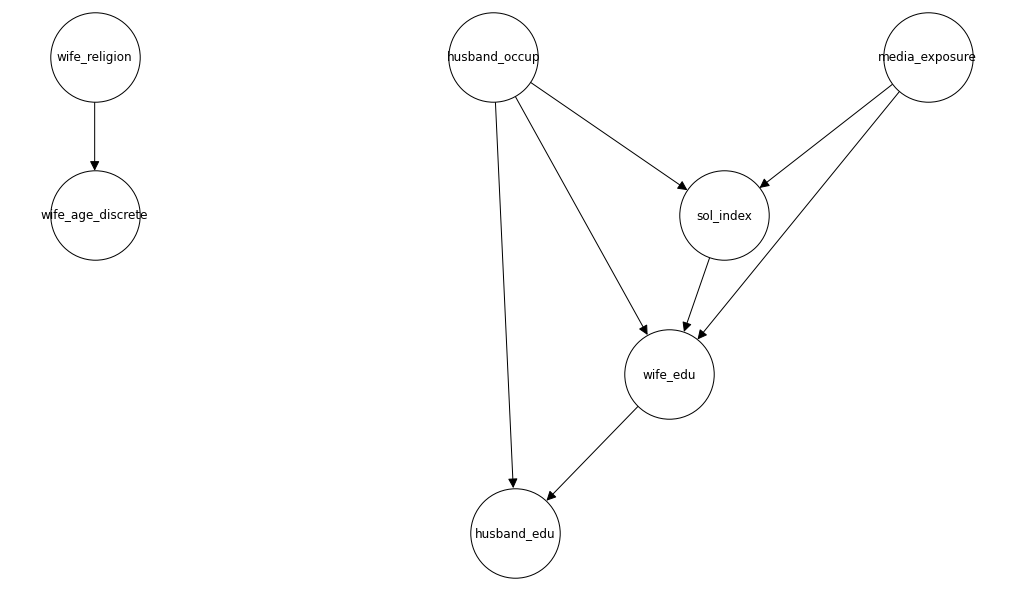

In [151]:
est = PC(X)
best_model = est.estimate()
plot_network(best_model)

#### Mmhc (hybrid)

First estimates a graph skeleton using MMPC and then orients the edges using score-based local search (hill climbing). Does not work in current lib version.

  0%|                                                                                      | 0/1000000 [00:00<?, ?it/s]


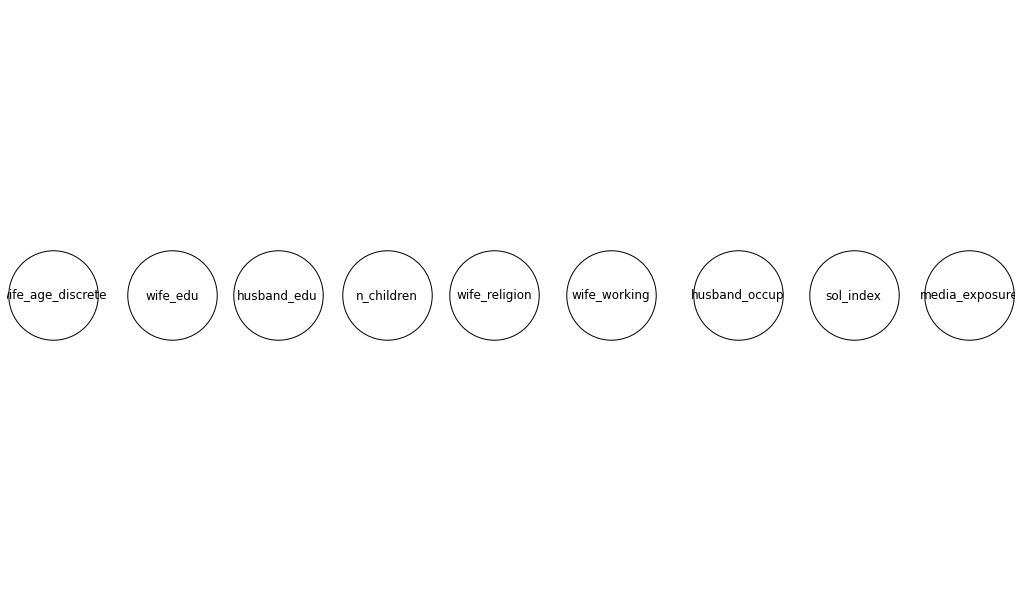

In [152]:
est = MmhcEstimator(X)
best_model = est.estimate(scoring_method=K2Score(X))
plot_network(best_model)

### Bayesian Network empirical definition

In [177]:
model = BayesianModel([('wife_age_discrete', 'n_children'),   ('husband_edu', 'husband_occup'),   ('husband_edu', 'sol_index'),
                       ('wife_edu', 'sol_index'),  ('sol_index', 'media_exposure'),   ('wife_age_discrete', 'wife_working'),
                       ('wife_edu', 'wife_working'),  ('wife_working', 'sol_index'),  ('wife_working', 'n_children'),
                       ('husband_occup', 'n_children'),('husband_occup', 'sol_index')])
model.add_node('wife_religion')

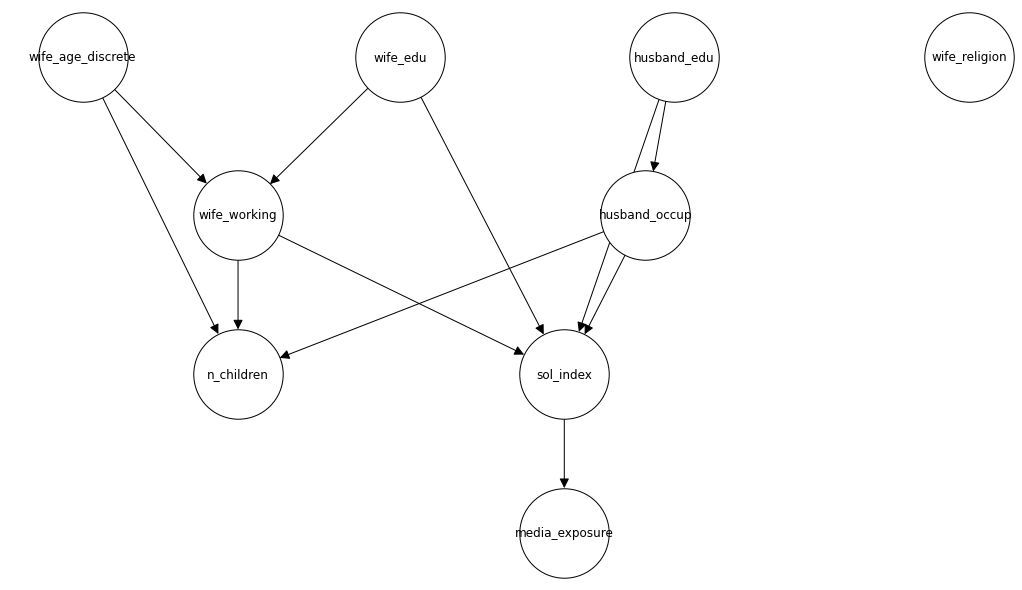

In [178]:
plot_network(model)

### Generated structures based on empirical exploration 

  0%|                                                                          | 13/1000000 [00:01<38:26:24,  7.23it/s]


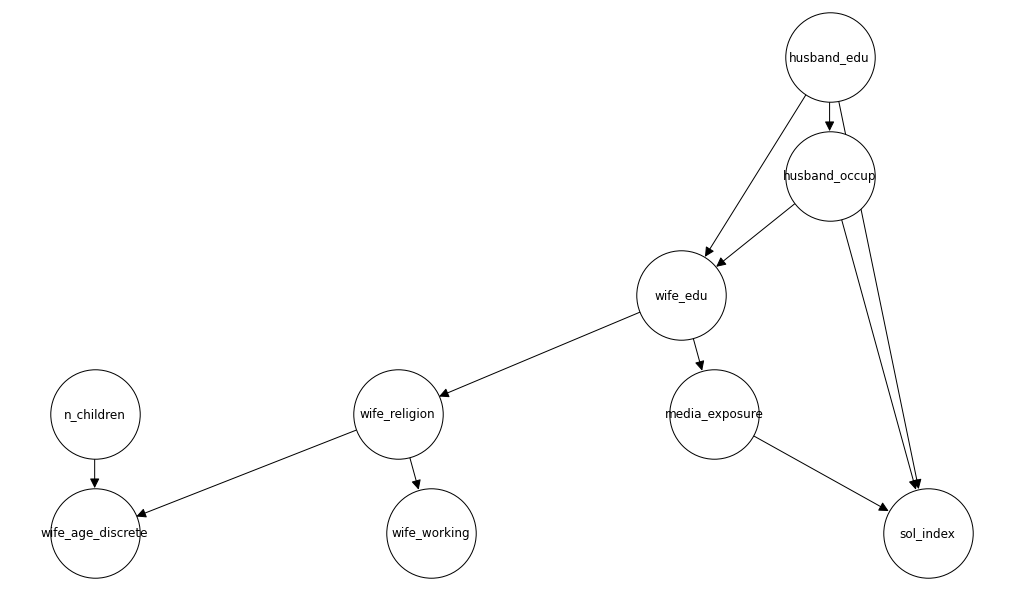

In [183]:
est = HillClimbSearch(X)
best_model = est.estimate(scoring_method=K2Score(X), start_dag = model)
plot_network(best_model)

  0%|                                                                           | 3/1000000 [00:00<85:27:45,  3.25it/s]


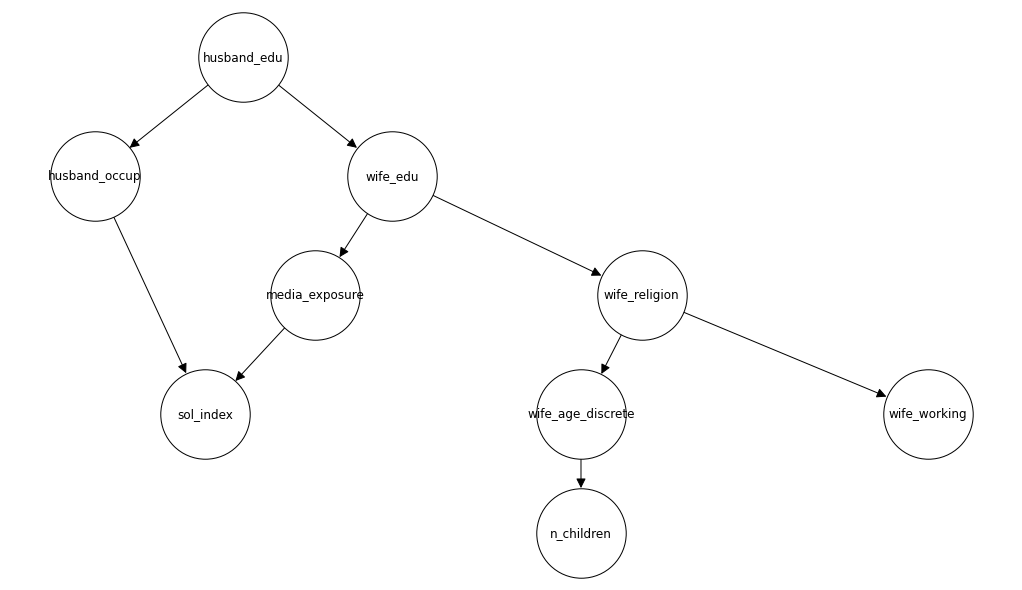

In [187]:
est = HillClimbSearch(X)
best_model = est.estimate(scoring_method=BDeuScore(X), start_dag = model)
plot_network(best_model)

### Model exploration

In [179]:
model.get_independencies()

(wife_age_discrete ⟂ husband_occup, husband_edu, wife_edu, wife_religion)
(wife_age_discrete ⟂ husband_occup, wife_edu, wife_religion | husband_edu)
(wife_age_discrete ⟂ wife_religion | media_exposure)
(wife_age_discrete ⟂ husband_edu, wife_edu, husband_occup | wife_religion)
(wife_age_discrete ⟂ husband_occup, husband_edu, wife_religion | wife_working)
(wife_age_discrete ⟂ media_exposure, wife_religion | sol_index)
(wife_age_discrete ⟂ husband_occup, husband_edu, wife_religion | wife_edu)
(wife_age_discrete ⟂ wife_religion | n_children)
(wife_age_discrete ⟂ husband_edu, wife_edu, wife_religion | husband_occup)
(wife_age_discrete ⟂ wife_religion | husband_edu, media_exposure)
(wife_age_discrete ⟂ wife_edu, husband_occup | husband_edu, wife_religion)
(wife_age_discrete ⟂ wife_religion, husband_occup | wife_working, husband_edu)
(wife_age_discrete ⟂ media_exposure, wife_religion | husband_edu, sol_index)
(wife_age_discrete ⟂ wife_religion, husband_occup | husband_edu, wife_edu)
(wife_age

In [188]:
model.local_independencies('n_children')

(n_children ⟂ wife_working, husband_occup, sol_index, husband_edu, wife_edu, media_exposure, wife_religion | wife_age_discrete)